In [3]:
import random
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns

from string import digits
import string
from nltk.stem.porter import *

import tensorflow as tf

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('~/data/yelp/yelp_reviews.csv')
data = data.sample(n=50000, replace=False) 

In [5]:
data = ((data[['user_id', 'business_id', 'city', 'stars_x', 'text', 'date', 'name_x', 'name_y', 'stars_y', 'review_count_y', 'is_open', 'attributes', 'categories', 'hours']])
        .rename(columns={'stars_x': 'review_rating', 'name_x':'user_name', 'name_y': 'restaurant_name', 'review_count_y':'num_reviews', 'stars_y':'restaurant_rating'}))

In [6]:
data['popularity'] = data['num_reviews'] /  data['restaurant_rating']

In [7]:
trainData, testData = sklearn.model_selection.train_test_split(data)

X_train = (trainData.drop(columns=['review_rating']))
y_train = (trainData['review_rating'])

X_test = (testData.drop(columns=['review_rating']))
y_test = (testData['review_rating'])


# BPR Model (Adapted from Julian McAuley's code in chapter 6 https://cseweb.ucsd.edu/~jmcauley/pml/code/chap6.html)

In [6]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])

        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [7]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet.difference(interactionsTestPerUser[u]),N)
    for i,j in zip(positive,negative):
        si = model.predict(userIDs[u], itemIDs[i]).numpy()
        sj = model.predict(userIDs[u], itemIDs[j]).numpy()
        if si > sj:
            win += 1
    return win/N

In [8]:
def AUC(model):
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

# Pre-Processing

In [9]:
interactions = []

userIDs = {}
itemIDs = {}
for row in range(len(data)):
    u = data.iloc[row]['user_id']
    i = data.iloc[row]['business_id']

    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    
    
    interactions.append((u, i))

items = list(itemIDs.keys())

itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)

for row in range(len(X_train)):
    u = X_train.iloc[row]['user_id']
    i = X_train.iloc[row]['business_id']
    
    usersPerItem[i].append(u)
    itemsPerUser[u].append(i)

In [10]:
userandcity = data[['user_id', 'city', 'business_id', 'date']]

userCity = defaultdict(str)
tracker = 0
for user in userandcity['user_id'].unique():
    businesses = []
    shorter = userandcity[userandcity['user_id'] == user].sort_values('date', ascending=False)
    businesses.append(shorter['city'].iloc[0])
    # for item in itemsPerUser[user]:
    #     business = data.loc[data['business_id']==item]['city'].unique()
    #     businesses.append(business)

    if len(businesses) != 0:
        #userCity[user] = pd.Series(businesses).value_counts().idxmax().item()
        userCity[user] = businesses[0]
    else:
        userCity[user] = 'Las Vegas'#np.random.choice(data['city'].unique())
    
    if tracker % 10000 == 0:
        print(tracker)
    tracker += 1


0
10000
20000
30000
40000


In [11]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for row in range(len(X_test)):
    u = X_test.iloc[row]['user_id']
    i = X_test.iloc[row]['business_id']

    interactionsTestPerUser[u].add(i)
    itemSet.add(i)

# Training the Model

In [12]:
aucs = []
for attempt in [0.1, 0.5, 0.9]:
    optimizer = tf.keras.optimizers.Adam(attempt)
    modelBPR = BPRbatch(10, 0.00001)

    losses = []
    for i in range(100):
        obj = trainingStepBPR(modelBPR, interactions)
        losses.append(obj)
        #if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

    aucs.append((attempt, AUC(modelBPR)))
    

In [13]:
aucs

[(0.1, 0.789991975872278),
 (0.5, 0.8122298774245318),
 (0.9, 0.8092429650535403)]

In [15]:
lambs = []
for lamb in [0.00001, 0.005, 0.1]:
    optimizer = tf.keras.optimizers.Adam(0.01)
    modelBPR = BPRbatch(10, lamb)

    losses = []
    for i in range(100):
        obj = trainingStepBPR(modelBPR, interactions)
        losses.append(obj)
        #if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

    lambs.append((lamb, AUC(modelBPR)))

In [16]:
lambs

[(1e-05, 0.6592443485238372),
 (0.005, 0.5657494258598268),
 (0.1, 0.5418748789463491)]

In [ ]:
#lossPlot = sns.lineplot(x=range(len(losses)), y=losses).set(xlabel='Epoch', ylabel='Loss', title='Training Loss')

In [ ]:
#lossPlot

# AUC with positive and negative sampling for BPR

In [13]:
## TOOK 16 MINUTES ##
AUC(modelBPR)

0.5210950735244291

# RIDGE MODEL

In [8]:
all_categories = defaultdict(int)
def clean_text(text):
    punct = string.punctuation
    text = text.replace("\n", ' ').replace("\t", ' ').lower().strip()
    text = [c for c in text if not (c in punct)]
    text = ''.join(text)
    text = text.strip().replace("  ",' ')
    for i in text.split():
        all_categories[i] += 1
    return text

In [9]:
data['categories'] = data['categories'].astype(str)
data['categories'] = data['categories'].apply(clean_text)

catDf = pd.DataFrame(np.zeros([len(data), len(all_categories)]), columns=all_categories)

In [10]:
## LONG ~5 MIN ##
for i in range(len(data)):
    for j in data.iloc[i]['categories'].split():
        catDf.iloc[i][j] = 1

In [11]:
subData = pd.concat([data[['restaurant_rating', 'num_reviews', 'is_open', 'popularity', 'review_rating']].reset_index(drop=True), catDf], axis=1).astype(np.float32)
#subData = pd.concat([subData, data[['user_id']].reset_index(drop=True)], axis=1)

In [12]:
trainData, testData = sklearn.model_selection.train_test_split(subData)

X_train = np.array(trainData.drop(columns=['review_rating']))
y_train = np.array(trainData['review_rating'])

X_test = np.array(testData.drop(columns=['review_rating']))
y_test = np.array(testData['review_rating'])


In [25]:
ridge_mses = []
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9,]
for a in alphas:
    model = Ridge(alpha=a, normalize=True)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(preds, y_test)
    ridge_mses.append(mse)

In [26]:
ridge_mses

[1.7646408,
 1.7632651,
 1.7620567,
 1.7571847,
 1.7556378,
 1.7671311,
 1.7872031,
 1.8080482,
 1.827752]

[Text(0.5, 1.0, 'Ridge Regression Model MSE | 50,000 Samples'),
 Text(0.5, 0, 'Regularization Coefficient'),
 Text(0, 0.5, 'MSE')]

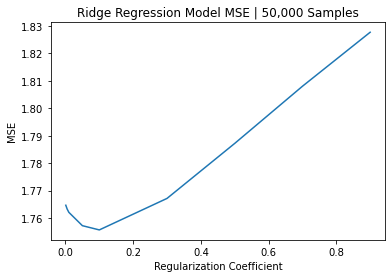

In [27]:
sns.lineplot(x=alphas, y=ridge_mses).set(title='Ridge Regression Model MSE | 50,000 Samples', xlabel='Regularization Coefficient', ylabel='MSE')

In [23]:
pped = np.array(subData.drop(columns=['restaurant_rating']))

In [24]:
test_preds = []
for i, j in list(enumerate(pped)):
    test_pred = model.predict(j.reshape(1, -1))
    test_preds.append((i, test_pred.item()))


In [25]:
test_preds.sort(key=lambda x:x[1], reverse=True)

In [26]:
top = data.iloc[[i[0] for i in test_preds]]

# Recommender

In [27]:
def recommend(user, N, inputCity=None):
    outputs = []
    # COLD START 
    if user not in data['user_id'].unique():
        # If city not specified (will recommend over all locations by popularity)
        if inputCity != None:
            locals = data[data['city'] == inputCity]
            outputs = locals.sort_values('popularity', ascending=False)['restaurant_name'].unique()[:N]
            print('cold start | city specified: {}'.format(inputCity))
        # If city is specified (will recommend over city by popularity)
        else:
            outputs = data.sort_values('popularity', ascending=False)['restaurant_name'].unique()[:N]
            print('cold start | no city specified, user location: North America')
    # WARM START
    else:
        # If city not specified (finds automatically, recommends by BPR)
        if inputCity == None:
            preds = []
            for i in data[data['city'] == userCity[user]]['business_id'].unique():
                pred = modelBPR.predict(userIDs[user], itemIDs[i]).numpy()
                preds.append((i, pred))

            preds.sort(key=lambda x: x[1])
            preds.reverse()

            
            for i, j in preds[:N]:
                output = data[data['business_id'] == i]['restaurant_name'].unique()
                outputs.append(output.item())
            print('warm start | no city specified, user location: {}'.format(userCity[user]))
        
        # If city is passed specified (recommends by BPR)
        else:
            preds = []
            for i in data[data['city'] == inputCity]['business_id'].unique():
                pred = modelBPR.predict(userIDs[user], itemIDs[i]).numpy()
                preds.append((i, pred))

            preds.sort(key=lambda x: x[1])
            preds.reverse()

            
            for i, j in preds[:N]:
                output = data[data['business_id'] == i]['restaurant_name'].unique()
                outputs.append(output.item())
            print('warm start | city specified: {}'.format(inputCity))

    # COMBINATION with Ridge Model
    # Get intersection of BPR and ridge models with BPR priority
    # The BPR priority is so that we don't recommend the same things each time and add 
    # user specificity

    # city specified
    if inputCity != None:
        localTop = top[top['city'] == inputCity]['restaurant_name'].unique()
    # city not specified
    else:
        localTop = top[top['city'] == userCity[user]]['restaurant_name'].unique()

    ridgeTop = list(localTop[:10])
    
    theBest = []
    for i in outputs:
        for j in ridgeTop:
            if i == j:
                theBest.append(i)


    # Ensure we get some recommendations
    if len(theBest) < N:
        theBest = outputs[:N]

    return theBest[:N]

In [32]:
recommend(data.iloc[0]['user_id'], 10, 'Las Vegas')

warm start | city specified: Las Vegas


['Bacchanal Buffet',
 'Hash House A Go Go',
 'Mon Ami Gabi',
 'Holsteins',
 'Flamingo Las Vegas Hotel & Casino',
 'Gordon Ramsay BurGR',
 'Lotus of Siam',
 'Earl of Sandwich',
 'Gordon Ramsay Pub & Grill',
 'Luxor Hotel and Casino Las Vegas']

In [33]:
recommend(data.iloc[0]['user_id'], 10)

warm start | no city specified, user location: Toronto


['Grand Electric',
 'Seven Lives Tacos Y Mariscos',
 'Khao San Road',
 "Lil' Baci",
 "Rachel's Coffee House",
 'Hokkaido Ramen Santouka',
 'Karbouzi',
 'Gusto 101',
 'Mad Dog Cafe',
 'Oskar On Scollard']

In [30]:
recommend('newUser', 10, 'Phoenix')

cold start | city specified: Phoenix


array(['Cox Communications', 'Snooze, An A.M. Eatery',
       'Phoenix Sky Harbor International Airport', 'Bobby Q',
       'Pizzeria Bianco', 'The Arrogant Butcher', 'Lux Central',
       'La Santisima Gourmet Taco Shop', "Lo-Lo's Chicken & Waffles",
       "Matt's Big Breakfast"], dtype=object)

In [31]:
recommend('newUser_With_Location_Off', 10)

cold start | no city specified, user location: North America


array(['Bacchanal Buffet', 'Mon Ami Gabi', 'Wicked Spoon',
       'Luxor Hotel and Casino Las Vegas', 'Hash House A Go Go',
       'Flamingo Las Vegas Hotel & Casino',
       'Circus Circus Las Vegas Hotel and Casino', 'MGM Grand Hotel',
       'Gordon Ramsay BurGR', 'The Buffet At Wynn'], dtype=object)